In [99]:
# import package
# installed via pip
from emtracks.particle import * # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm


rad13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)rad/'
reg13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)/'
mao13datadir = '/home/shared_data/mao10,mao13_analysis/data/mao13contourplots3/'

In [100]:
files = sorted(os.listdir(mao13datadir)) #all your files

In [101]:
files

['0.90_2.080_0.000_0.054_.pkl',
 '0.90_2.080_0.128_0.054_.pkl',
 '0.90_2.080_0.256_0.054_.pkl',
 '0.90_2.080_0.385_0.054_.pkl',
 '0.90_2.080_0.513_0.054_.pkl',
 '0.90_2.080_0.641_0.054_.pkl',
 '0.90_2.080_0.769_0.054_.pkl',
 '0.90_2.080_0.898_0.054_.pkl',
 '0.90_2.080_1.026_0.054_.pkl',
 '0.90_2.080_1.154_0.054_.pkl',
 '0.90_2.080_1.282_0.054_.pkl',
 '0.90_2.080_1.411_0.054_.pkl',
 '0.90_2.080_1.539_0.054_.pkl',
 '0.90_2.080_1.667_0.054_.pkl',
 '0.90_2.080_1.795_0.054_.pkl',
 '0.90_2.080_1.923_0.054_.pkl',
 '0.90_2.080_2.052_0.054_.pkl',
 '0.90_2.080_2.180_0.054_.pkl',
 '0.90_2.080_2.308_0.054_.pkl',
 '0.90_2.080_2.436_0.054_.pkl',
 '0.90_2.080_2.565_0.054_.pkl',
 '0.90_2.080_2.693_0.054_.pkl',
 '0.90_2.080_2.821_0.054_.pkl',
 '0.90_2.080_2.949_0.054_.pkl',
 '0.90_2.080_3.077_0.054_.pkl',
 '0.90_2.080_3.206_0.054_.pkl',
 '0.90_2.080_3.334_0.054_.pkl',
 '0.90_2.080_3.462_0.054_.pkl',
 '0.90_2.080_3.590_0.054_.pkl',
 '0.90_2.080_3.719_0.054_.pkl',
 '0.90_2.080_3.847_0.054_.pkl',
 '0.90_2

In [102]:
e_solvernom = trajectory_solver.from_pickle(mao13datadir+files[500])
e_solvernom.dataframe
e_solvernom.init_conds.theta0

2.0942857142857143

In [103]:
files[0].split('_')

['0.90', '2.080', '0.000', '0.054', '.pkl']

In [104]:
bounce = True

In [202]:
info = []
deleted = []
for file in files:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    field = file.split('_')[0]
    phi = e_solvernom.init_conds.phi0
    theta = e_solvernom.init_conds.theta0
    
    if e_solvernom.dataframe.z.max() < 7.00:
        bounce = 0
    else:
        bounce = 1
        
    info.append([field, theta, phi, bounce])
    
df = pd.DataFrame(info, columns = ['field', 'theta', 'phi', 'bounce'])  

In [203]:
df['theta'].unique()

array([2.08      , 2.08142857, 2.08285714, 2.08428571, 2.08571429,
       2.08714286, 2.08857143, 2.09      , 2.09142857, 2.09285714,
       2.09428571, 2.09571429, 2.09714286, 2.09857143, 2.1       ,
       2.10142857, 2.10285714, 2.10428571, 2.10571429, 2.10714286,
       2.10857143, 2.11      , 2.11142857, 2.11285714, 2.11428571,
       2.11571429, 2.11714286, 2.11857143, 2.12      , 2.12142857,
       2.12285714, 2.12428571, 2.12571429, 2.12714286, 2.12857143,
       2.13      , 2.13142857, 2.13285714, 2.13428571, 2.13571429,
       2.13714286, 2.13857143, 2.14      , 2.14142857, 2.14285714,
       2.14428571, 2.14571429, 2.14714286, 2.14857143, 2.15      ])

In [204]:
zees = {}
for field in df['field'].unique():
    df2 = df[df['field']==field]
    dfbounce = df2[(df2['bounce']==1) & (df2['field']==field)]

    bounce = [] 
    for i in range(0, len(dfbounce['theta'].values), 1):
        bounce.append([dfbounce['theta'].values[i], dfbounce['phi'].values[i]]) #all pairs of [theta, phi] that bounce

    thetas = np.array(df2['theta'].unique())
    phis = np.array(df2['phi'].unique())
    z = np.zeros((len(phis), len(thetas)))

    for phi in range(0, len(phis), 1):
        for theta in range(0, len(thetas), 1):
            if [thetas[theta], phis[phi]] in bounce:
                z[phi][theta] = 1 
                
    zees.update({f'{field}':z})

In [205]:
zees

{'0.90': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.91': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.92': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.93': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 

Text(0.5, 0.98, 'Particles that Bounce in Different Distorted TS Field Scenarios')

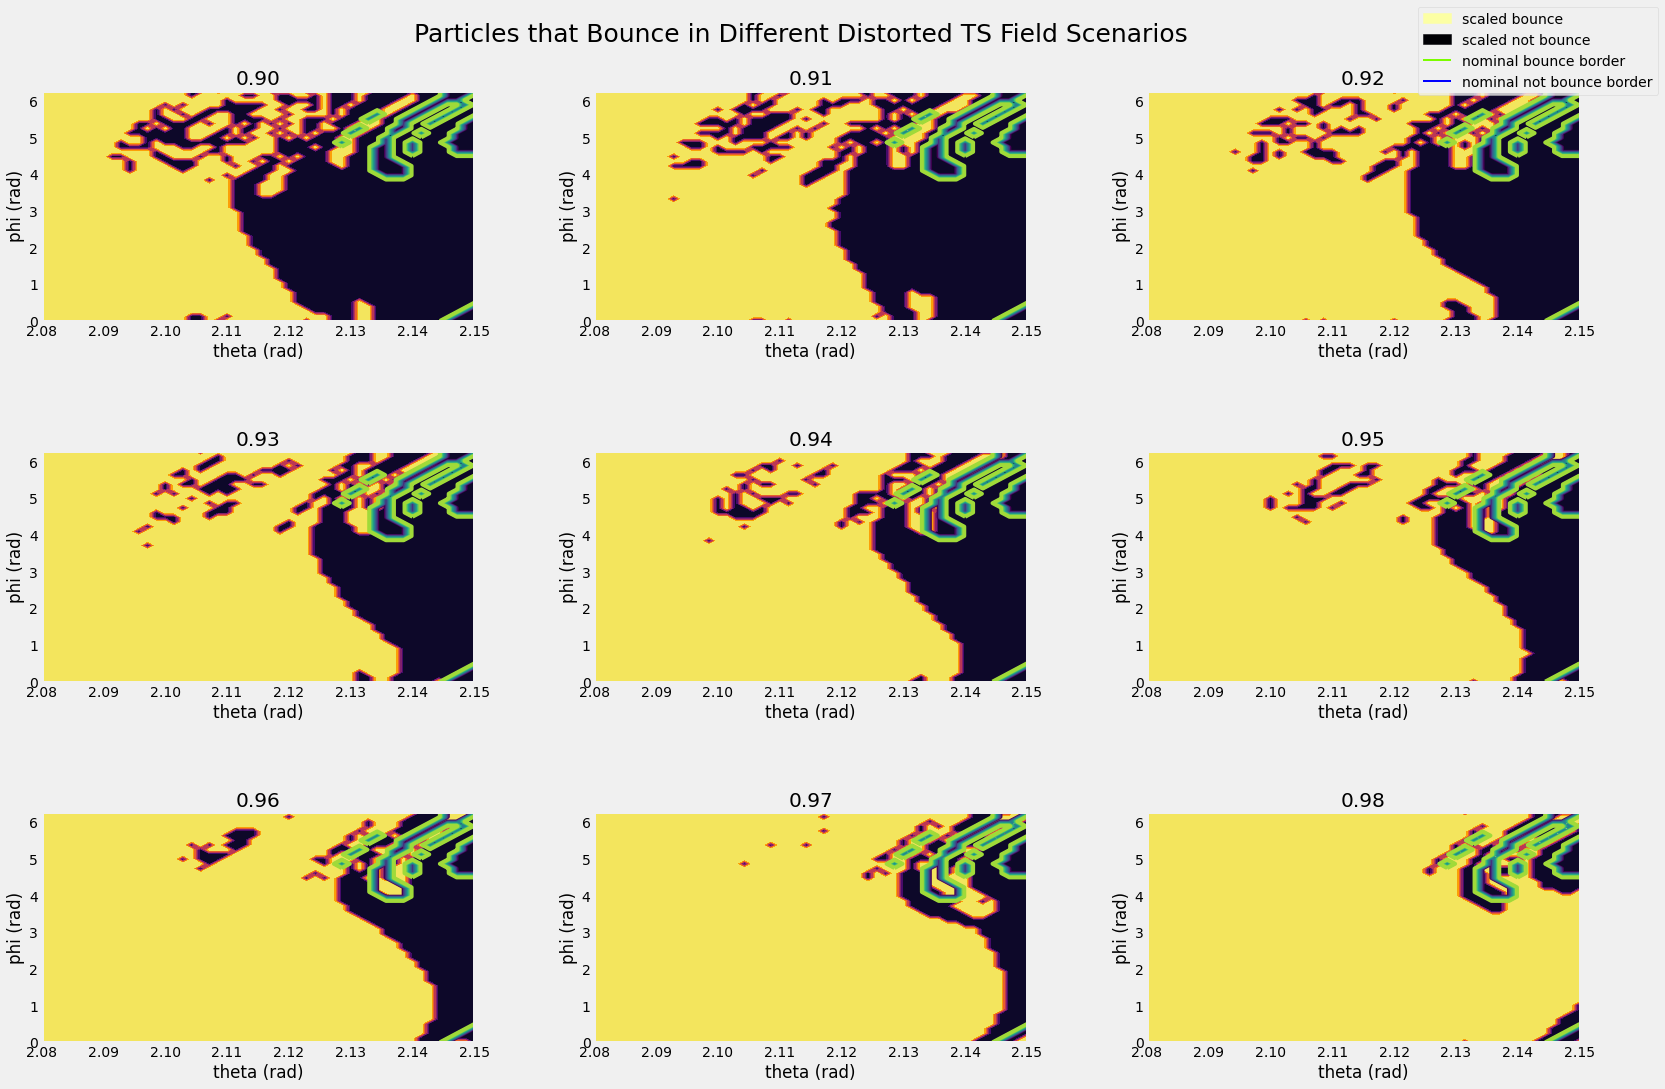

In [243]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
fig = plt.figure()
ax1 = plt.subplot2grid((3,3), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3,3), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3,3), (1,0), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((3,3), (1,1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((3,3), (1,2), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((3,3), (2,0), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((3,3), (2,1), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((3,3), (2,2), rowspan=1, colspan=1)


ax1.contourf(thetas, phis, zees['0.90'], cmap = 'inferno')
ax1.set_title(f'0.90')
ax1.set_xlabel(f'theta (rad)')
ax1.set_ylabel(f'phi (rad)')
ax1.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax2.contourf(thetas, phis, zees['0.91'], cmap = 'inferno')
ax2.set_title(f'0.91')
ax2.set_xlabel(f'theta (rad)')
ax2.set_ylabel(f'phi (rad)')
ax2.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax3.contourf(thetas, phis, zees['0.92'], cmap = 'inferno')
ax3.set_title(f'0.92')
ax3.set_xlabel(f'theta (rad)')
ax3.set_ylabel(f'phi (rad)')
ax3.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax4.contourf(thetas, phis, zees['0.93'], cmap = 'inferno')
ax4.set_title(f'0.93')
ax4.set_xlabel(f'theta (rad)')
ax4.set_ylabel(f'phi (rad)')
ax4.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax5.contourf(thetas, phis, zees['0.94'], cmap = 'inferno')
ax5.set_title(f'0.94')
ax5.set_xlabel(f'theta (rad)')
ax5.set_ylabel(f'phi (rad)')
ax5.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax6.contourf(thetas, phis, zees['0.95'], cmap = 'inferno')
ax6.set_title(f'0.95')
ax6.set_xlabel(f'theta (rad)')
ax6.set_ylabel(f'phi (rad)')
ax6.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax7.contourf(thetas, phis, zees['0.96'], cmap = 'inferno')
ax7.set_title(f'0.96')
ax7.set_xlabel(f'theta (rad)')
ax7.set_ylabel(f'phi (rad)')
ax7.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax8.contourf(thetas, phis, zees['0.97'], cmap = 'inferno')
ax8.set_title(f'0.97')
ax8.set_xlabel(f'theta (rad)')
ax8.set_ylabel(f'phi (rad)')
ax8.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax9.contourf(thetas, phis, zees['0.98'], cmap = 'inferno')
ax9.set_title(f'0.98')
ax9.set_xlabel(f'theta (rad)')
ax9.set_ylabel(f'phi (rad)')
ax9.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

cmap = plt.cm.get_cmap('inferno')
rgba = cmap(0.0)
rgba2 = cmap(1.0)
bounces = mpatches.Patch(color=rgba, label = 'scaled not bounce')
notbounces = mpatches.Patch(color=rgba2, label = 'scaled bounce')
 
nomcmap = plt.cm.get_cmap('viridis')
rgba3 = nomcmap(1.0)
rgba4 = nomcmap(0.0)
overlay = Line2D([0], [0], color='lawngreen', lw = 2, label = 'nominal bounce border')
overlay2 = Line2D([0], [0], color='blue', lw = 2, label = 'nominal not bounce border')
fig.legend(handles = [notbounces, bounces, overlay, overlay2])


fig.tight_layout(pad = 5.0)
fig.suptitle('Particles that Bounce in Different Distorted TS Field Scenarios', fontsize = '25')

In [207]:
zeees = {}
for field in df['field'].unique():
    thetadif = (thetas[-1] - thetas[0])/(len(thetas))
    phidif = (phis[-1] - phis[0])/(len(phis))
    scaledthetas = []
    scaledphis = []
    for theta in thetas:
        scaledthetas.append(theta-thetadif)
    scaledthetas.append(thetas[-1] + thetadif)

    for phi in phis:
        scaledphis.append(phi-phidif)
    scaledphis.append(phis[-1] + phidif)
    
    zeees.update({f'{field}': [scaledthetas, scaledphis]})

Text(0.5, 0.98, 'Particles that Bounce in Different Distorted TS Field Scenarios')

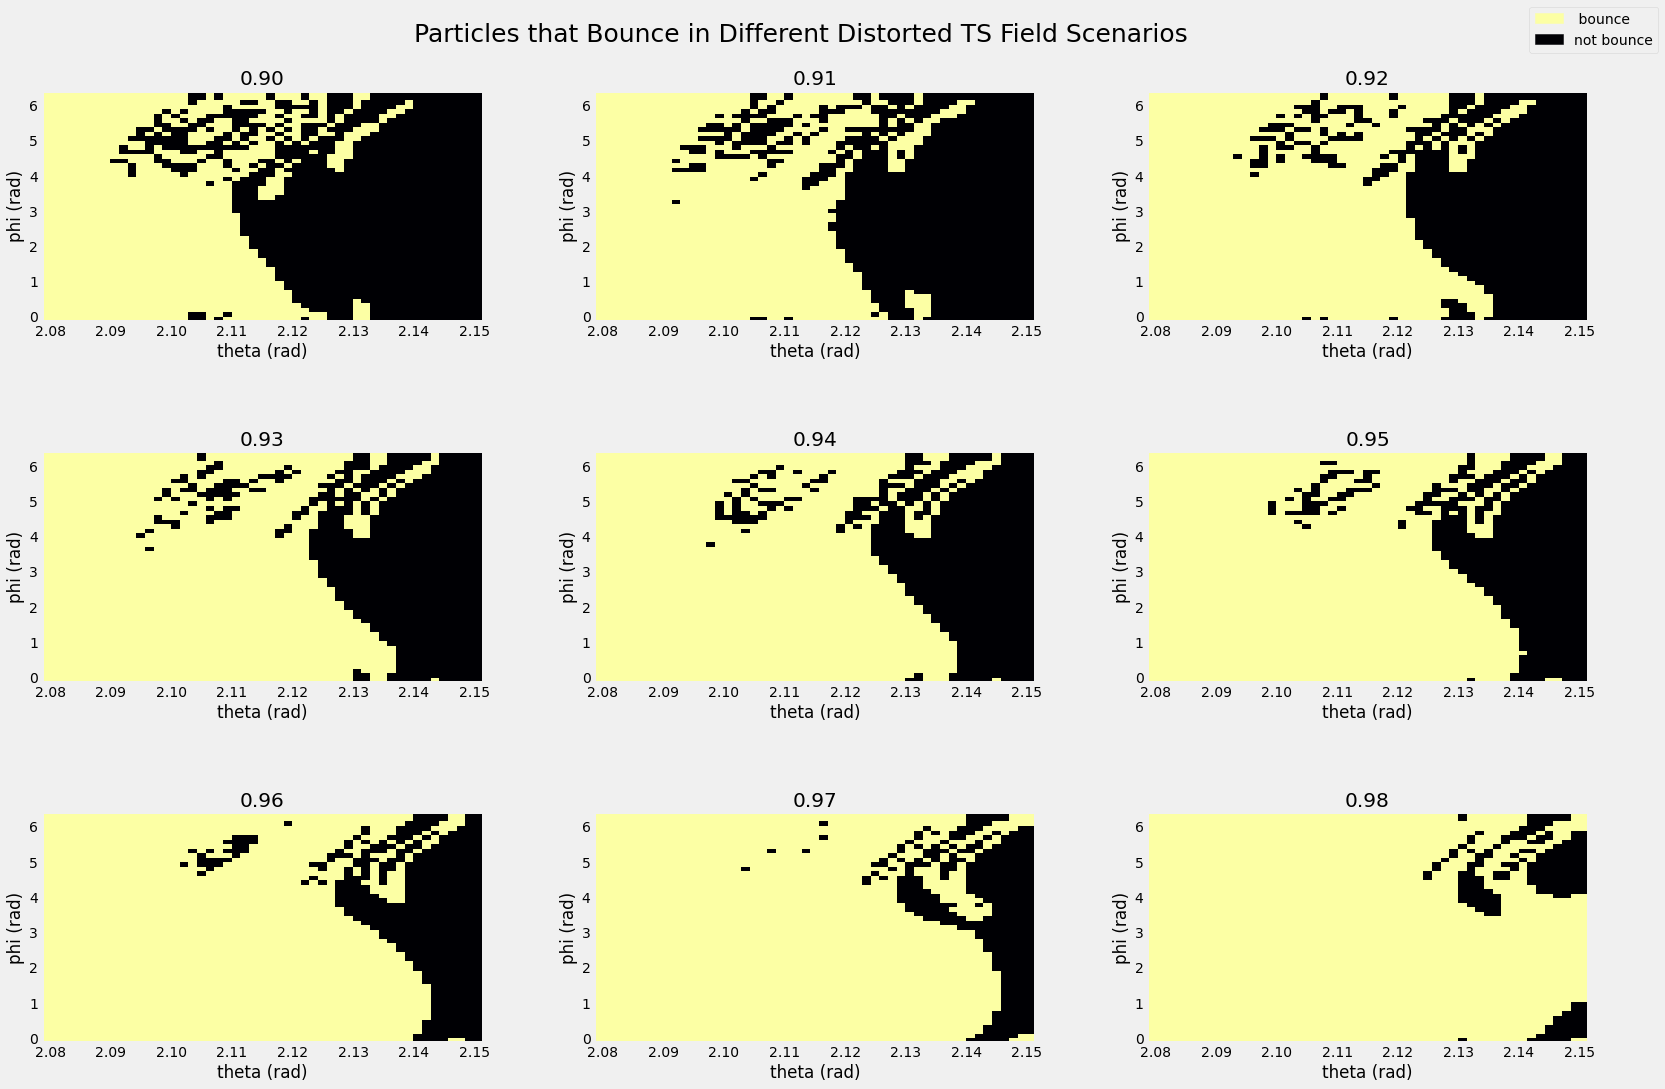

In [208]:
fig = plt.figure()
ax1 = plt.subplot2grid((3,3), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3,3), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3,3), (1,0), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((3,3), (1,1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((3,3), (1,2), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((3,3), (2,0), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((3,3), (2,1), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((3,3), (2,2), rowspan=1, colspan=1)

ax1.pcolormesh(zeees['0.90'][0], zeees['0.90'][1], zees['0.90'], cmap = 'inferno')
ax1.set_title(f'0.90')
ax1.set_xlabel(f'theta (rad)')
ax1.set_ylabel(f'phi (rad)')

ax2.pcolormesh(zeees['0.91'][0], zeees['0.91'][1], zees['0.91'], cmap = 'inferno')
ax2.set_title(f'0.91')
ax2.set_xlabel(f'theta (rad)')
ax2.set_ylabel(f'phi (rad)')

ax3.pcolormesh(zeees['0.92'][0], zeees['0.92'][1], zees['0.92'], cmap = 'inferno')
ax3.set_title(f'0.92')
ax3.set_xlabel(f'theta (rad)')
ax3.set_ylabel(f'phi (rad)')

ax4.pcolormesh(zeees['0.93'][0], zeees['0.93'][1], zees['0.93'], cmap = 'inferno')
ax4.set_title(f'0.93')
ax4.set_xlabel(f'theta (rad)')
ax4.set_ylabel(f'phi (rad)')

ax5.pcolormesh(zeees['0.94'][0], zeees['0.94'][1], zees['0.94'], cmap = 'inferno')
ax5.set_title(f'0.94')
ax5.set_xlabel(f'theta (rad)')
ax5.set_ylabel(f'phi (rad)')

ax6.pcolormesh(zeees['0.95'][0], zeees['0.95'][1], zees['0.95'], cmap = 'inferno')
ax6.set_title(f'0.95')
ax6.set_xlabel(f'theta (rad)')
ax6.set_ylabel(f'phi (rad)')

ax7.pcolormesh(zeees['0.96'][0], zeees['0.96'][1], zees['0.96'], cmap = 'inferno')
ax7.set_title(f'0.96')
ax7.set_xlabel(f'theta (rad)')
ax7.set_ylabel(f'phi (rad)')

ax8.pcolormesh(zeees['0.97'][0], zeees['0.97'][1], zees['0.97'], cmap = 'inferno')
ax8.set_title(f'0.97')
ax8.set_xlabel(f'theta (rad)')
ax8.set_ylabel(f'phi (rad)')

ax9.pcolormesh(zeees['0.98'][0], zeees['0.98'][1], zees['0.98'], cmap = 'inferno')
ax9.set_title(f'0.98')
ax9.set_xlabel(f'theta (rad)')
ax9.set_ylabel(f'phi (rad)')



cmap = plt.cm.get_cmap('inferno')
rgba = cmap(0.0)
rgba2 = cmap(1.0)
bounces = mpatches.Patch(color=rgba, label = 'not bounce')
notbounces = mpatches.Patch(color=rgba2, label = ' bounce')
fig.legend(handles = [notbounces, bounces])


fig.tight_layout(pad = 5.0)
fig.suptitle('Particles that Bounce in Different Distorted TS Field Scenarios', fontsize = '25')


In [74]:
field = '0.90'
dfbounce = df[(df['bounce']==1) & (df['field']==field)]
dfno = df[(df['bounce']==0) & (df['field']==field)]

In [ ]:
thetasbounce = np.array(dfbounce['theta'].values)
phisbounce = np.array(dfbounce['phi'].values)

thetasno = np.array(dfno['theta'].values)
phisno = np.array(dfno['phi'].values)

In [ ]:
z = 

In [ ]:
df['field'].unique()
for field in df['field'].unique():
    dfnew = df[df['field']==field]
    dfnew.dropna()
    x = np.array(dfnew['theta'].values)
    y = np.array(dfnew['phi'].values)
    z = dfnew['bounce'].values
    fig = plt.figure()
    plt.scatter(x, y, 1)
    

In [ ]:
def getDSfield(file):
    return file.split('_')[1].split('x')[0]
def getPSfield(file):
    return file.split('_')[2].split('x')[0]

def getfiles(files, field, thetas, phis):
    fieldrounded = round(field, 3)
    thetasrounded = [round(num, 3) for num in thetas]
    phisrounded = [round(num, 3) for num in phis]
    
    filedata = []
    for file in files:
        if np.isclose(float(file.split('_')[0]), field, 1e-3):
            if float(getDSfield(file)) in thetasrounded:
                if float(getPSfield(file)) in phisrounded:
                    filedata.append(file)
    
    return filedata

filenames = getfiles(files, 0.90, data, phis)
filenames2 = getfiles(files, 1.00, data, phis)

#filenames - all files with data, phis and field = 0.90, filenames2 '' 

In [ ]:
def readpklold(zstart, zend, numpoints, files):
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []
    deleted = []

    for file in files:
        x = file.split('_')
        field = x[0]
        e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            if z > e_solvernom.dataframe.z.max() or z < e_solvernom.dataframe.z.min():
                data.append(8*[np.nan])
                deleted.append([e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
            else:
                info = interp_cole(e_solvernom.dataframe, z)
                x = info[1]
                y = info[2]
                r = tuple([(x**2 + y**2)**(1/2)])
                r2 = tuple([((x-0.054094482)**(2) + (y-0.03873037)**(2))**(1/2)])
                tuple1 = (z, field, theta, phi)
                
                nan = tuple([np.nan])

                data.append(tuple1 + info + r + r2)
                
    return data, deleted

In [ ]:
x, deleted = readpklold(6, 13, 8, filenames) #dis 

In [ ]:
len(deleted)

In [ ]:
y, deleted2 = readpklold(6, 13, 8, filenames2) #norm

In [ ]:
len(deleted2)

In [ ]:
dfdis = pd.DataFrame(deleted, columns = ['theta', 'phi']) #dis
dfnom = pd.DataFrame(deleted2, columns = ['theta', 'phi']) #nom

In [ ]:
dfdis

In [ ]:
dfdis['theta'].unique()

In [ ]:
dfnom['theta'].unique()

In [ ]:
#above two lines say in dis theta with 2.11, 2.17 have deleted values due to bounds
#however, nom theta with 2.17 only have deleted values due to bounds

In [ ]:
missingphis = dfdis[np.isclose(dfdis['theta'], 2.11576648, 1e-2)]['phi'].unique()
len(missingphis)

In [ ]:
missingphis2 = []
missingphis3 = dfdis[np.isclose(dfdis['theta'], 2.17988062, 1e-2)]['phi'].unique()
missingphis4 = dfnom[np.isclose(dfnom['theta'], 2.17988062, 1e-2)]['phi'].unique()
for phi in missingphis3:
    if phi in missingphis4:
        x = 1
    else:
        missingphis2.append(phi)
#get all the missingphis in the distorted field that are not in the nominal field
len(missingphis2)

In [ ]:
thetadata = [2.11576648]
def getfiles(files, field, thetas, phis):
    fieldrounded = round(field, 3)
    thetasrounded = [round(num, 3) for num in thetas]
    phisrounded = [round(num, 3) for num in phis]
    
    filedata = []
    for file in files:
        if np.isclose(float(file.split('_')[0]), field, 1e-3):
            if float(getDSfield(file)) in thetasrounded:
                if float(getPSfield(file)) in phisrounded:
                    filedata.append(file)
    
    return filedata

filedata = getfiles(files, 0.90, thetadata, missingphis)
filedata2 = getfiles(files, 1.00, thetadata, missingphis)

In [ ]:
#all the file names with the missingphis and theta = 2.115766

In [ ]:
thetadata2 = [2.17988062]
filedata3 = getfiles(files, 0.90, thetadata2, missingphis2)
filedata4 = getfiles(files, 1.00, thetadata2, missingphis2)

In [ ]:
#all the file names with missing phis and theta = 2.179

In [ ]:
maxzdis = []
for file in filedata:
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+file)
    maxzdis.append([max(e_solverdis.dataframe.z.values), e_solverdis.init_conds.theta0, e_solverdis.init_conds.phi0])

maxz = []
for file in filedata2:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    maxz.append([max(e_solvernom.dataframe.z.values), e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
    


In [ ]:
maxz

In [ ]:
maxzdis

In [ ]:
maxzdis2 = []
for file in filedata3:
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+file)
    maxzdis2.append([max(e_solverdis.dataframe.z.values), e_solverdis.init_conds.theta0, e_solverdis.init_conds.phi0])

maxz2 = []
for file in filedata4:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    maxz2.append([max(e_solvernom.dataframe.z.values), e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
    


In [ ]:
maxz2

In [ ]:
maxzdis2

In [ ]:
filedata[0]
filedata2[0]
def plots(filenom, filedis):
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+filenom)
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+filedis)

    xs = e_solvernom.dataframe.x.values
    ys = e_solvernom.dataframe.y.values
    zs = e_solvernom.dataframe.z.values

    xs2 = e_solverdis.dataframe.x.values
    ys2 = e_solverdis.dataframe.y.values
    zs2 = e_solverdis.dataframe.z.values

    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.scatter(xs, ys, zs, c = 'b')
    ax.scatter(xs2, ys2, zs2, c = 'r')
    
plots(filedata2[3], filedata[3])

In [ ]:
plots(filedata4[17], filedata3[17])